# Introduction

This notebook operates in a similar way to a Jupyter Notebook. The notebook consist of the following sections:

1.   SQL queries
2.   Exploratory Analysis and Data visualization
3.   Classification Model Development



## Package Imports


In [0]:
# Run this cell

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

!pip install pandasql
import pandasql as pdsql
pysql = lambda q: pdsql.sqldf(q, globals())

  Created wheel for pandasql: filename=pandasql-0.7.3-cp36-none-any.whl size=26820 sha256=a789a73e3f2dfd050a9fb94febc0bbe27122e70c8463a07372306f2b986b07a3
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


## Import Data

We will be using a Bank Marketing dataset from [OpenML](https://www.openml.org/d/1461). This dataset is from direct marketing campaigns of a Portuguese bank. The marketing campaigns were based on phone calls to see if the client would be interested in opening a term deposit account. Often, clients were contacted more than once for them to confirm whether they would or would not open a term deposit account.


*   The dataset has 17 columns and 45311 rows
*   The target, has the client opened a term deposit accounts (open_term_deposit) is binary. 
*   open_term_deposit = 1 if the client has not opened an account
*   open_term_deposit = 2 if the client has opened as account

You can find more information about this dataset [here](https://www.openml.org/d/1461)

In [0]:
# Run this cell

# Get data from OpenML
dataset = fetch_openml(name='bank-marketing')

# Assign column names (known from https://www.openml.org/d/1461)
f_names = ['age',
           'job',
           'marital_status',
           'education',
           'credit_in_default',
           'avg_balance_annual',
           'has_housing_loan',
           'has_personal_loan',
           'contact_type',
           'last_contact_day',
           'last_contact_month',
           'last_contact_duration',
           'during_campaign_contact_count',
           'days_since_contact_pre_campaign',
           'pre_campaign_contact_count',
           'pre_campaign_outcome']
target =  'open_term_deposit'

# Save data into a dataframe
df = pd.DataFrame(dataset.data, columns=f_names)

# All data
df[target] = dataset.target

/usr/local/lib/python3.6/dist-packages/sklearn/datasets/_openml.py:372: UserWarning: Multiple active versions of the dataset matching the name bank-marketing exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))


# SQL






This section consists of several SQL questions. We are using a library called `pandasql` which allows us to apply SQL queries directly to a Pandas DataFrame and return a Pandas DataFrame of the resulting table. 

First, we are going to split the loaded dataset `df` into 2 dataframes, `clients` and `historic_contact`. 

*   `clients` is a dataframe which contains the clients attributes and the target, `open_term_deposit`. 
*    `historic_contact` is a dataframe which contains data about when a client was contacted by the bank during their marketing campaigns. 




In [0]:
# Run this cell

# Split data into two DataFrame for SQL exercise

# Clients table
client_columns = ['age',
                'job',
                'marital_status',
                'education',
                'credit_in_default',
                'avg_balance_annual',
                'has_housing_loan',
                'has_personal_loan',
                'open_term_deposit']
clients = df[client_columns].reset_index().copy()
clients.columns.values[0] = 'id'

# Historic contact table
contact_columns = ['contact_type',
                  'last_contact_day',
                  'last_contact_month',
                  'last_contact_duration',
                  'during_campaign_contact_count',
                  'days_since_contact_pre_campaign',
                  'pre_campaign_contact_count',
                  'pre_campaign_outcome']
historic_contact = df[contact_columns].reset_index().copy()
historic_contact['client_id'] = clients['id']


The first 5 rows of each DataFrame are displayed below:


In [0]:
# Run this cell

clients.head()

,id,age,job,marital_status,education,credit_in_default,avg_balance_annual,has_housing_loan,has_personal_loan,open_term_deposit
0,0,58.0,4.0,1.0,2.0,0.0,2143.0,1.0,0.0,1
1,1,44.0,9.0,2.0,1.0,0.0,29.0,1.0,0.0,1
2,2,33.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,1
3,3,47.0,1.0,1.0,3.0,0.0,1506.0,1.0,0.0,1
4,4,33.0,11.0,2.0,3.0,0.0,1.0,0.0,0.0,1


In [0]:
# Run this cell

historic_contact.head()

,index,contact_type,last_contact_day,last_contact_month,last_contact_duration,during_campaign_contact_count,days_since_contact_pre_campaign,pre_campaign_contact_count,pre_campaign_outcome,client_id
0,0,2.0,5.0,8.0,261.0,1.0,-1.0,0.0,3.0,0
1,1,2.0,5.0,8.0,151.0,1.0,-1.0,0.0,3.0,1
2,2,2.0,5.0,8.0,76.0,1.0,-1.0,0.0,3.0,2
3,3,2.0,5.0,8.0,92.0,1.0,-1.0,0.0,3.0,3
4,4,2.0,5.0,8.0,198.0,1.0,-1.0,0.0,3.0,4


Using the knowledge of the data contained in `clients` and `historic_contact`

Simply replace the text `ADD QUERY HERE` with your SQL statement, execute the cell and the results will be printed out. 


1.
From the `clients` dataframe, find the average `avg_balance_annual` for each education level, ordered by the average avg_balance_annual


In [0]:
# Input required
'''TO do this, I specify the two columns that I want to work with
    avg_balance_annual and education. Then, use AVG function to calculate the average balance annual
    and group by function for proper segmentation '''

q1 = """SELECT AVG(avg_balance_annual), education 
        FROM clients 
        GROUP BY education;"""
q1_res = pysql(q1)
q1_res

,AVG(avg_balance_annual),education
0,1250.949934,0.0
1,1154.880786,1.0
2,1758.416435,2.0
3,1526.754443,3.0


From the clients dataframe and for education level 2 & 3, find the proportion of clients with a housing loan and the proportion **with** a personal loan

In [0]:
# Input required
''' Some useful functions were COUNT, IN and GROUP BY
'''
q2 = """ SELECT COUNT(has_housing_loan),COUNT(has_personal_loan), education 
         FROM clients
         WHERE education IN (2,3)
         AND has_personal_loan = 1 AND has_housing_loan = 1
         GROUP BY education;
     """
q2_res = pysql(q2)
q2_res

,COUNT(has_housing_loan),COUNT(has_personal_loan),education
0,1058,1058,2.0
1,74,74,3.0


Join the clients table to the historic_contact table and reduce the dataset to only included clients who **have** been contacted in the past. 

Note: historic_contact.days_since_contact_pre_campaign == -1 if the client **has not** been contacted.

In [0]:
# Input required
"""
Using INNER JOIN where days_since_contact_pre_campaign is different from 1
"""
q3 = ''' SELECT * FROM clients
         INNER JOIN historic_contact
         ON clients.id = historic_contact.client_id
         WHERE days_since_contact_pre_campaign != -1
     '''
q3_res = pysql(q3)
q3_res

,id,age,job,marital_status,education,credit_in_default,avg_balance_annual,has_housing_loan,has_personal_loan,open_term_deposit,index,contact_type,last_contact_day,last_contact_month,last_contact_duration,during_campaign_contact_count,days_since_contact_pre_campaign,pre_campaign_contact_count,pre_campaign_outcome,client_id
0,24060,33.0,0.0,1.0,2.0,0.0,882.0,0.0,0.0,1,24060,1.0,21.0,10.0,39.0,1.0,151.0,3.0,0.0,24060
1,24062,42.0,0.0,2.0,1.0,0.0,-247.0,1.0,1.0,2,24062,1.0,21.0,10.0,519.0,1.0,166.0,1.0,1.0,24062
2,24064,33.0,7.0,1.0,1.0,0.0,3444.0,1.0,0.0,2,24064,1.0,21.0,10.0,144.0,1.0,91.0,4.0,0.0,24064
3,24072,36.0,4.0,1.0,2.0,0.0,2415.0,1.0,0.0,1,24072,1.0,22.0,10.0,73.0,1.0,86.0,4.0,1.0,24072
4,24077,36.0,4.0,1.0,2.0,0.0,0.0,1.0,0.0,2,24077,1.0,23.0,10.0,140.0,1.0,143.0,3.0,0.0,24077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8252,45199,34.0,1.0,2.0,1.0,0.0,1475.0,1.0,0.0,1,45199,0.0,16.0,9.0,1166.0,3.0,530.0,12.0,1.0,45199
8253,45201,53.0,4.0,1.0,2.0,0.0,583.0,0.0,0.0,2,45201,0.0,17.0,9.0,226.0,1.0,184.0,4.0,2.0,45201
8254,45204,73.0,5.0,1.0,1.0,0.0,2850.0,0.0,0.0,2,45204,0.0,17.0,9.0,300.0,1.0,40.0,8.0,0.0,45204
8255,45208,72.0,5.0,1.0,1.0,0.0,5715.0,0.0,0.0,2,45208,0.0,17.0,9.0,1127.0,5.0,184.0,3.0,2.0,45208


Find the number of clients that were last contacted in each month. 

Select the 3 months where the proportion of clients who opened a term deposit account is the greatest. 

hint: open_term_deposit = [1,2] which represents clients who have not and have opened term deposit accounts respectively. 

In [0]:
# Input required

q4 = ''' SELECT COUNT(last_contact_month) , last_contact_month
         FROM q3_res
         WHERE open_term_deposit = 2 
         ORDER BY COUNT(last_contact_month) DESC LIMIT 3
     '''
q4_res = pysql(q4)
q4_res

,COUNT(last_contact_month),last_contact_month
0,1905,9.0


In [0]:
historic_contact.tail()

,index,contact_type,last_contact_day,last_contact_month,last_contact_duration,during_campaign_contact_count,days_since_contact_pre_campaign,pre_campaign_contact_count,pre_campaign_outcome,client_id
45206,45206,0.0,17.0,9.0,977.0,3.0,-1.0,0.0,3.0,45206
45207,45207,0.0,17.0,9.0,456.0,2.0,-1.0,0.0,3.0,45207
45208,45208,0.0,17.0,9.0,1127.0,5.0,184.0,3.0,2.0,45208
45209,45209,1.0,17.0,9.0,508.0,4.0,-1.0,0.0,3.0,45209
45210,45210,0.0,17.0,9.0,361.0,2.0,188.0,11.0,1.0,45210


# Section 2: Exploratory Data Analysis and Data Visualization

In the following section, the goal is to explore which clients are likely to open a term deposit account. Using data analysis techniques and data visualizations, I explore the relationship between the features and the target variable, `open_term_deposit`. 

**I should also identify 5 features to use for predictive model.
Prompts:
*   Explore distributions and descriptions statistics
*   Use data vizualization* to help understand the dataset
*   Investigate for predictive relationships between features and the target.




In [0]:
# Run this cell

# First 5 rows of the dataset
df.head()

,age,job,marital_status,education,credit_in_default,avg_balance_annual,has_housing_loan,has_personal_loan,contact_type,last_contact_day,last_contact_month,last_contact_duration,during_campaign_contact_count,days_since_contact_pre_campaign,pre_campaign_contact_count,pre_campaign_outcome,open_term_deposit
0,58.0,4.0,1.0,2.0,0.0,2143.0,1.0,0.0,2.0,5.0,8.0,261.0,1.0,-1.0,0.0,3.0,1
1,44.0,9.0,2.0,1.0,0.0,29.0,1.0,0.0,2.0,5.0,8.0,151.0,1.0,-1.0,0.0,3.0,1
2,33.0,2.0,1.0,1.0,0.0,2.0,1.0,1.0,2.0,5.0,8.0,76.0,1.0,-1.0,0.0,3.0,1
3,47.0,1.0,1.0,3.0,0.0,1506.0,1.0,0.0,2.0,5.0,8.0,92.0,1.0,-1.0,0.0,3.0,1
4,33.0,11.0,2.0,3.0,0.0,1.0,0.0,0.0,2.0,5.0,8.0,198.0,1.0,-1.0,0.0,3.0,1


In [0]:
#Run this cell

# Converting the target to be binary [0,1] from binary [1,2]
df['open_term_deposit'] = df.open_term_deposit.astype(int) - 1

# List the features and their data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age                                45211 non-null float64
job                                45211 non-null float64
marital_status                     45211 non-null float64
education                          45211 non-null float64
credit_in_default                  45211 non-null float64
avg_balance_annual                 45211 non-null float64
has_housing_loan                   45211 non-null float64
has_personal_loan                  45211 non-null float64
contact_type                       45211 non-null float64
last_contact_day                   45211 non-null float64
last_contact_month                 45211 non-null float64
last_contact_duration              45211 non-null float64
during_campaign_contact_count      45211 non-null float64
days_since_contact_pre_campaign    45211 non-null float64
pre_campaign_contact_count         45211 non-null float64
pre_campaign_outcome 

In [0]:
# Run this cell

# Descriptive statistics
df.describe()

,age,job,marital_status,education,credit_in_default,avg_balance_annual,has_housing_loan,has_personal_loan,contact_type,last_contact_day,last_contact_month,last_contact_duration,during_campaign_contact_count,days_since_contact_pre_campaign,pre_campaign_contact_count,pre_campaign_outcome,open_term_deposit
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,4.339762,1.167725,1.224813,0.018027,1362.272058,0.555838,0.160226,0.640242,15.806419,5.523014,258.163080,2.763841,40.197828,0.580323,2.559974,0.116985
std,10.618762,3.272657,0.608230,0.747997,0.133049,3044.765829,0.496878,0.366820,0.897951,8.322476,3.006911,257.527812,3.098021,100.128746,2.303441,0.989059,0.321406
min,18.000000,0.000000,0.000000,0.000000,0.000000,-8019.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
25%,33.000000,1.000000,1.000000,1.000000,0.000000,72.000000,0.000000,0.000000,0.000000,8.000000,3.000000,103.000000,1.000000,-1.000000,0.000000,3.000000,0.000000
50%,39.000000,4.000000,1.000000,1.000000,0.000000,448.000000,1.000000,0.000000,0.000000,16.000000,6.000000,180.000000,2.000000,-1.000000,0.000000,3.000000,0.000000
75%,48.000000,7.000000,2.000000,2.000000,0.000000,1428.000000,1.000000,0.000000,2.000000,21.000000,8.000000,319.000000,3.000000,-1.000000,0.000000,3.000000,0.000000
max,95.000000,11.000000,2.000000,3.000000,1.000000,102127.000000,1.000000,1.000000,2.000000,31.000000,11.000000,4918.000000,63.000000,871.000000,275.000000,3.000000,1.000000


In [0]:
# Start your Exploratory Analysis below

In [0]:
# Viewing how many datapoints represents clients who have not or have opened term deposit accounts
df["open_term_deposit"].value_counts()

0    39922
1     5289
Name: open_term_deposit, dtype: int64

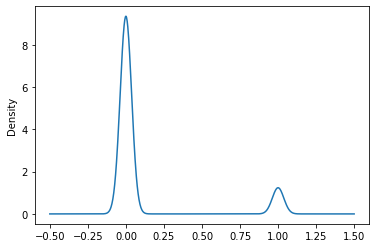

In [0]:
# probability distribution function for dependent varible
ax = df["open_term_deposit"].plot.kde()
#df_new

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74a9b2fc88>,
      dtype=object)

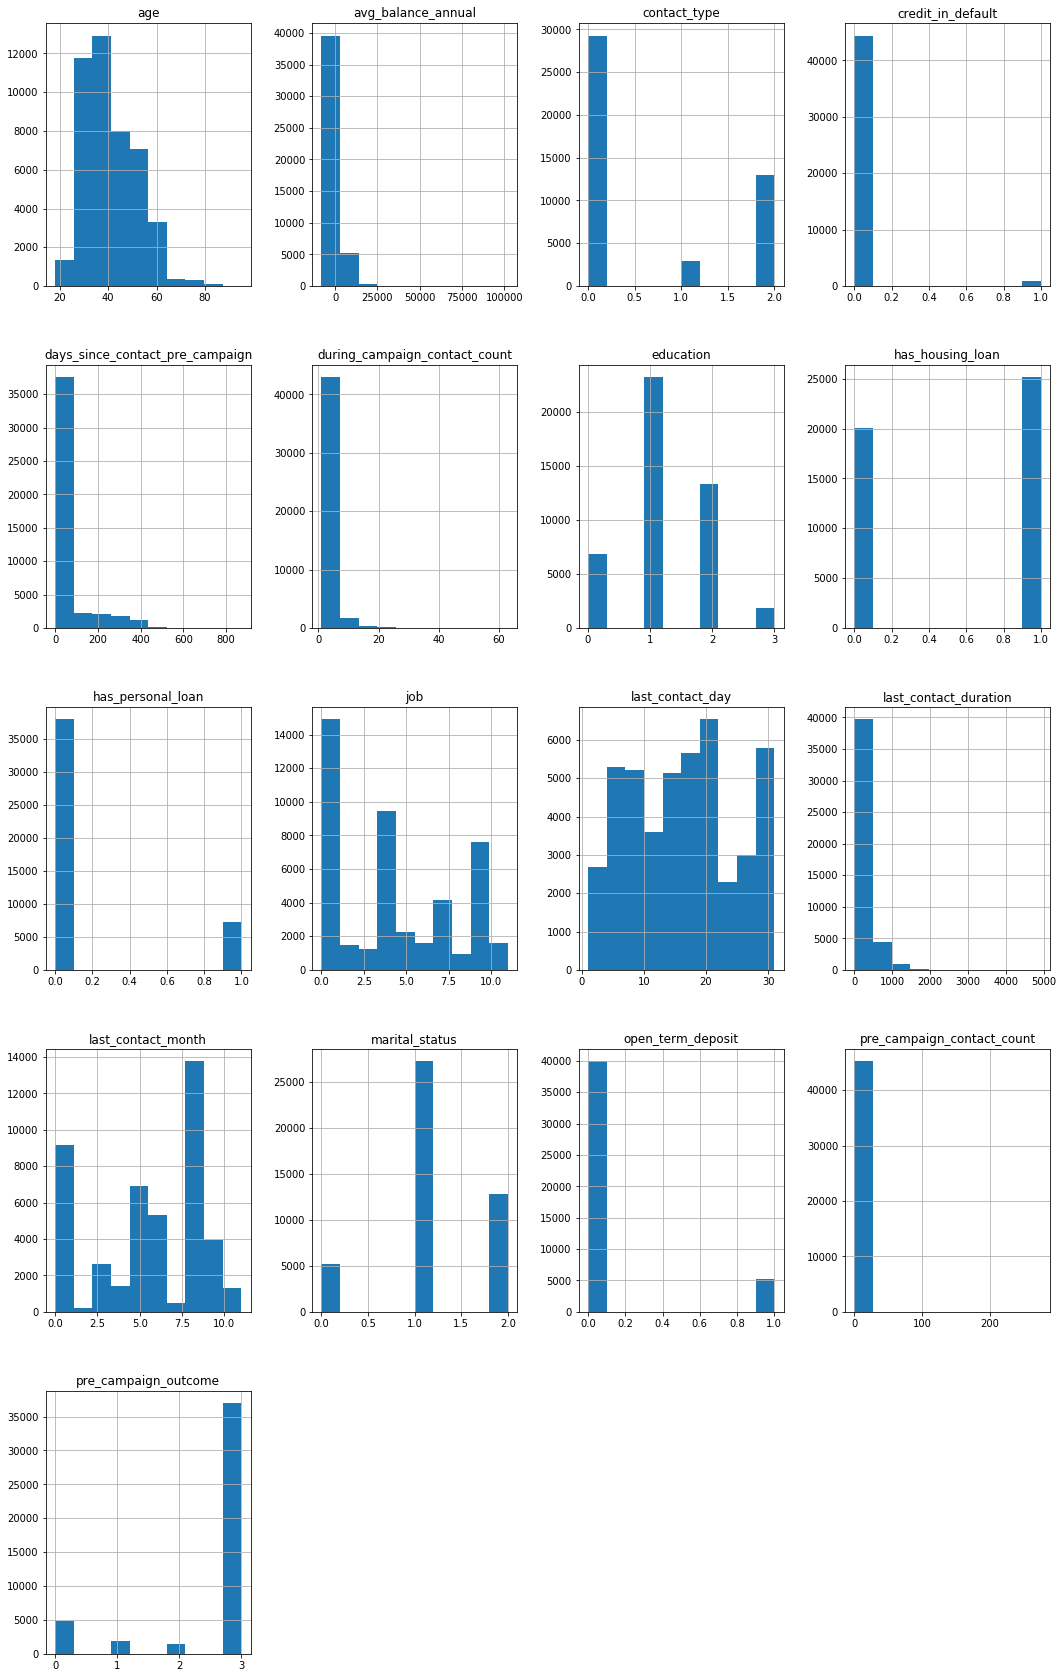

In [0]:
# histogram to help in viewing the distribution for each varible
fig = plt.figure(figsize = (18, 30))
ax = fig.gca()
df.hist(ax = ax)


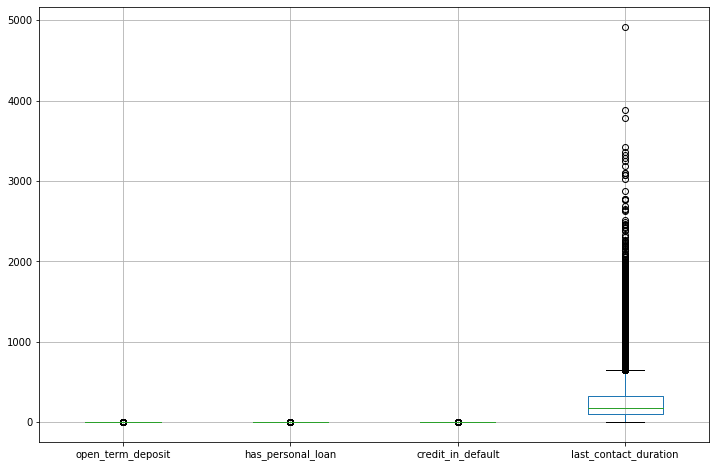

In [0]:
#Using boxplot to detect outliers
boxplot = df.boxplot(column=['open_term_deposit', 'has_personal_loan', 'credit_in_default', 'last_contact_duration'], figsize=(12,8))

In [0]:
#correlation to identify the relationship between open_term_deposit and all independent variables
corr_values = df.corr()
corr_values.style.background_gradient(cmap='coolwarm')

,age,job,marital_status,education,credit_in_default,avg_balance_annual,has_housing_loan,has_personal_loan,contact_type,last_contact_day,last_contact_month,last_contact_duration,during_campaign_contact_count,days_since_contact_pre_campaign,pre_campaign_contact_count,pre_campaign_outcome,open_term_deposit
age,1,-0.0218679,-0.40324,-0.106807,-0.0178793,0.0977827,-0.185513,-0.0156553,0.0262211,-0.00912005,-0.0423574,-0.00464843,0.00476031,-0.023758,0.00128832,0.0073669,0.025155
job,-0.0218679,1,0.0620455,0.166707,-0.00685309,0.0182315,-0.125363,-0.0330039,-0.0820633,0.0228556,-0.0928696,0.00474364,0.00683863,-0.024455,-0.000910617,0.0110104,0.040438
marital_status,-0.40324,0.0620455,1,0.108576,-0.00702337,0.00212192,-0.0160959,-0.0468925,-0.0392014,-0.00526136,-0.00699066,0.0118522,-0.0089941,0.0191723,0.0149732,-0.0168505,0.0455875
education,-0.106807,0.166707,0.108576,1,-0.0107177,0.064514,-0.0907902,-0.0485735,-0.110928,0.022671,-0.0573038,0.0019351,0.00625514,5.2355e-05,0.0175696,-0.0193614,0.0662406
credit_in_default,-0.0178793,-0.00685309,-0.00702337,-0.0107177,1,-0.0667451,-0.00602522,0.0772342,0.0154041,0.0094239,0.0114858,-0.0100215,0.0168215,-0.0299794,-0.0183294,0.0348982,-0.022419
avg_balance_annual,0.0977827,0.0182315,0.00212192,0.064514,-0.0667451,1,-0.0687683,-0.0843502,-0.0272729,0.00450259,0.0197772,0.0215604,-0.0145783,0.00343532,0.0166736,-0.0209673,0.0528384
has_housing_loan,-0.185513,-0.125363,-0.0160959,-0.0907902,-0.00602522,-0.0687683,1,0.0413229,0.188123,-0.0279816,0.271481,0.00507545,-0.0235987,0.124178,0.0370761,-0.0999707,-0.139173
has_personal_loan,-0.0156553,-0.0330039,-0.0468925,-0.0485735,0.0772342,-0.0843502,0.0413229,1,-0.010873,0.0113702,0.0221449,-0.012412,0.00997985,-0.0227536,-0.0110435,0.0154578,-0.068185
contact_type,0.0262211,-0.0820633,-0.0392014,-0.110928,0.0154041,-0.0272729,0.188123,-0.010873,1,-0.0279362,0.361145,-0.0208393,0.0196144,-0.244816,-0.147811,0.272214,-0.148395
last_contact_day,-0.00912005,0.0228556,-0.00526136,0.022671,0.0094239,0.00450259,-0.0279816,0.0113702,-0.0279362,1,-0.00602768,-0.0302063,0.16249,-0.0930441,-0.0517105,0.0834597,-0.0283478


The selected 5 features are last_contact_duration due to high correlation with open_term_deposit, has_personal_loan because it has a similar distribution to open_term_deposit, same for credit_in_default. Also, days_since_contact_pre_campaign and pre_campaign_contact_count has higher correlation to dependent variable (open_term_deposit) compared to other independent variables.

# Section 3: Classification Model Development

In the following section, the goal is to develop a model capable of predicting which clients are likely to open a term deposit account. 

Create at simple classifier using a sklean RandomForestClassifer and 5 features selected from your exploratory analysis. 

Some prompts to get you start
- How will you evaluate the classifier and why? 
- How will you avoid overfitting? 

In [0]:
# Run this cell

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn import metrics
# Add additional imports here! 

I will use a large part of the dataset for training in order to give a model a higher possibility to learn the parameters. This will help to avoid overfitting. 70 % of the datasets to train the model and 30 % to test the model performance. 

In [0]:
#Creating training set and testing set 
feats = pd.DataFrame([df['education'], df['avg_balance_annual'], df['job'], df['days_since_contact_pre_campaign'], df['pre_campaign_contact_count']]).T
y = df['open_term_deposit']
#Splitting the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size=0.3)

In [0]:
#Creating a Gaussian Classifier
classifier=RandomForestClassifier(n_estimators=100)

#Training the model using the training dataset
classifier.fit(X_train,y_train)

#predicting which clients are likely to open a term deposit account
y_pred=classifier.predict(X_test)

In [0]:
#Evaluating the model based on accuracy in prediction
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.8808611029194928


The best way to evaluate the model on this particular problem is to use precision and recall.

In [0]:
average_precision = average_precision_score(y_test, y_pred)